In [ ]:
import kagglehub
luigimatteo_recipenlg_path = kagglehub.dataset_download('luigimatteo/recipenlg')

print('Data source import complete.')


100%|██████████| 638M/638M [00:12<00:00, 55.0MB/s]

Extracting files...


Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

path = 'Colab Notebooks/NLP/Progetti/Cooking'

os.chdir(f'/content/drive/MyDrive/{path}')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/NLP/Progetti/Cooking'

# Lib

In [ ]:
import numpy as np
import pandas as pd

# Loading

In [ ]:
df=pd.read_csv(f"{luigimatteo_recipenlg_path}/full_dataset.csv")
df.head(1)

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."


In [ ]:
df=df[["title","ingredients","directions","NER"]]
df.head(5)

,title,ingredients,directions,NER
0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...","[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....","[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...","[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...","[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...","[""peanut butter"", ""graham cracker crumbs"", ""bu..."


# Analysis

In [ ]:
df.iloc[1]["ingredients"].split(" ")[0]

'["1'

In [ ]:
import re
def clean_string(s):
    s = s.lower()  # (opzionale) porta tutto in minuscolo
    s = re.sub(r'[^\w\s]', '', s)  # rimuove tutto tranne lettere, numeri e spazi
    return s.strip()

In [ ]:
# sample = df.iloc[0]
# idx=0
documents = [
    [
        f"d{idx+1}",
        f"{sample['title']}  --  {clean_string(sample['ingredients'])} -- {clean_string(sample['directions'])}".strip()
    ]
    for idx, sample in df.iterrows()
]

# Creazione DataFrame
docs_df = pd.DataFrame(documents, columns=["docno", "text"])

In [ ]:
# empty=" "
# documents = [ f"{sample['title']} <br>   {clean_string(sample['ingredients'])}  <br>  {clean_string(sample['directions'])}" for _,sample in df.iterrows() ]


In [ ]:
documents[0]

['d1',
 'No-Bake Nut Cookies  --  1 c firmly packed brown sugar 12 c evaporated milk 12 tsp vanilla 12 c broken nuts pecans 2 tbsp butter or margarine 3 12 c bite size shredded rice biscuits -- in a heavy 2quart saucepan mix brown sugar nuts evaporated milk and butter or margarine stir over medium heat until mixture bubbles all over top boil and stir 5 minutes more take off heat stir in vanilla and cereal mix well using 2 teaspoons drop and shape into 30 clusters on wax paper let stand until firm about 30 minutes']

# Comparing Reusults

In [ ]:
import pandas as pd
from scipy.stats import spearmanr, kendalltau

def compare_rankings(my_ranking_ids, reference_ranking_ids, top_k=5, method="spearman"):

    if top_k:
        my_ranking_ids = my_ranking_ids[:top_k]
        reference_ranking_ids = reference_ranking_ids[:top_k]

    reference_ranking_ids=[int(i["id"]) for i in reference_ranking_ids]

    # Trova solo gli ID comuni
    common_ids = list(set(my_ranking_ids) & set(reference_ranking_ids))
    if not common_ids:
      print("Nessun ID in comune tra i due ranking.")
      return

    # Mappa gli ID ai ranking
    my_rank = {doc_id: rank for rank, doc_id in enumerate(my_ranking_ids)}
    ref_rank = {doc_id: rank for rank, doc_id in enumerate(reference_ranking_ids)}

    # Costruisci le liste di posizioni
    my_pos = []
    ref_pos = []
    for doc_id in common_ids:
        my_pos.append(my_rank[doc_id])
        ref_pos.append(ref_rank[doc_id])

    # Calcola correlazione
    if method == "spearman":
        correlation, _ = spearmanr(my_pos, ref_pos)
    elif method == "kendall":
        correlation, _ = kendalltau(my_pos, ref_pos)
    else:
      pass

    # Documenti fuori posizione
    discrepancies = []
    for doc_id in common_ids:
        delta = my_rank[doc_id] - ref_rank[doc_id]
        if abs(delta) > 0:
            discrepancies.append({
                "id": doc_id,
                "pos_mine": my_rank[doc_id],
                "pos_ref": ref_rank[doc_id],
                "delta": delta
            })


    print(f"Correlation: {correlation}")
    print(f"Num elements: {len(common_ids)}")
    print("Discrepancies:", sorted(discrepancies, key=lambda x: abs(x["pos_ref"]), reverse=False))
    return {
        "correlation": correlation,
        "num_discrepancies": len(discrepancies),
        "discrepancies": sorted(discrepancies, key=lambda x: abs(x["pos_ref"]), reverse=False)
    }


#First Indexing

In [ ]:
from sentence_transformers import SentenceTransformer, util
semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## TF-IDF

In [ ]:
%%capture
!pip install -q python-terrier==0.11.0

pd.set_option('display.max_colwidth', 150)

import pyterrier as pt

if not pt.started():
  pt.init()

In [ ]:
indexref = pt.IndexRef.of("/content/drive/MyDrive/Colab Notebooks/NLP/Progetti/Cooking/index_3docs/data.properties")
tf_idf_index = pt.IndexFactory.of(indexref)

br = pt.BatchRetrieve(tf_idf_index, wmodel="TF_IDF")

<ipython-input-14-a649bc6ae08f>:4: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  br = pt.BatchRetrieve(tf_idf_index, wmodel="TF_IDF")


In [ ]:
def tf_idf_indexing(query,k=50):
  tf_idf_results=br.search(query)
  return tf_idf_results[:50]["docid"]

## KNN

In [ ]:
%%capture
!pip install hnswlib
import os
import hnswlib

# Create empty index
hnswlib_index = hnswlib.Index(space='cosine', dim=384)

# Define hnswlib index path
index_path = "./emp_dialogue_hnswlib.index"

# Load index if available
if os.path.exists(index_path):
    print("Loading index...")
    hnswlib_index.load_index(index_path)

In [ ]:
def knn_indexing(query,k=50):
  query_embedding = semb_model.encode(query, convert_to_tensor=True)
  ids, distances = hnswlib_index.knn_query(query_embedding, k=50)
  return ids[0]

# REINDEXING

## Cos Similarity

In [ ]:
def cosine_reordering(query,id_lists):
  query_embedding = semb_model.encode(query, convert_to_tensor=True)
  results_embeddings=[semb_model.encode(docs_df.iloc[i]["text"], convert_to_tensor=True) for i in id_lists ]
  scores = [util.cos_sim(query_embedding, embedding) for embedding in results_embeddings]

  sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)

  # Mappa gli indici locali a quelli originali
  reordered_ids = [int(id_lists[i]) for i in sorted_indices]

  return reordered_ids

## Cross Encoder

In [ ]:
from sentence_transformers import CrossEncoder
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')


In [ ]:
def cross_encoder_reordering(query,id_lists):
  scores = xenc_model.predict([(query, docs_df.iloc[i]["text"]) for i in id_lists])
  return [int(id_lists[i]) for i in np.argsort(scores)[::-1]]

#Loading Results

In [ ]:
import json

with open("./queries_results.json", "r") as f:
    ref_data = json.load(f)


In [ ]:
ref_data[0]["result"][:5]

[{'id': 1298794,
  'motivazione': "La ricetta è letteralmente 'Banana Pasta', dove la banana è un ingrediente principale dell'impasto della pasta. Altissima rilevanza."},
 {'id': 1083821,
  'motivazione': "La ricetta 'Pasta From Hell' include esplicitamente pasta cotta e banane affettate come ingrediente chiave nella salsa. Molto rilevante."},
 {'id': 1213542,
  'motivazione': 'Simile al DOC N:1083821, questa versione di \'Pasta "From Hell"\' combina pasta (fettuccine) con banane affettate nella salsa. Molto rilevante.'},
 {'id': 1940739,
  'motivazione': "Un'altra variante di 'Pasta From Hell' che utilizza pasta (fettuccine) e banane affettate nella preparazione della salsa. Molto rilevante."},
 {'id': 1354028,
  'motivazione': "Ricetta 'Chef Schlesinger'S Pasta From Hell' che prevede l'uso di pasta (fettuccine) e banane affettate nella salsa. Molto rilevante."}]

In [ ]:
for row in ref_data:
  query=row["query"]
  print(query)

  top_k=10




  tf_idf_res=tf_idf_indexing(query)
  knn_res=knn_indexing(query)
  COS_TF=cosine_reordering(query,tf_idf_res)
  COS_KNN=cosine_reordering(query,knn_res)
  CROSS_TF=cross_encoder_reordering(query,tf_idf_res)
  CROSS_KNN=cross_encoder_reordering(query,knn_res)

  print("REF:")
  for i in range(top_k):
    print(f"POS: {i}  DOC N:{row['result'][i]['id']} DOC:{docs_df.iloc[int(row['result'][i]['id'])]['text']}")



  print("\n\nTF IDF")
  for i in range(top_k):
    print(f"POS: {i}  DOC N:{tf_idf_res[i]} : ", docs_df.iloc[tf_idf_res[i]]["text"])

  print("\n\nKNN")
  for i in range(top_k):
    print(f"POS: {i}  DOC N:{knn_res[i]} : ", docs_df.iloc[knn_res[i]]["text"])

  print("\n\nTF IDF + COSINE")
  for i in range(top_k):
    print(f"POS: {i}  DOC N:{COS_TF[i]} : ", docs_df.iloc[COS_TF[i]]["text"])

  print("\n\n KNN + COSINE")
  for i in range(top_k):
    print(f"POS: {i}  DOC N:{COS_KNN[i]} : ", docs_df.iloc[COS_KNN[i]]["text"])

  print("\n\nTF IDF + CROSS")
  for i in range(top_k):
    print(f"POS: {i}  DOC N:{CROSS_TF[i]} : ", docs_df.iloc[CROSS_TF[i]]["text"])


  print("\n\n KNN + CROSS")
  for i in range(top_k):
    print(f"POS: {i}  DOC N:{CROSS_KNN[i]} : ", docs_df.iloc[CROSS_KNN[i]]["text"])

  print("\n\n\n\n")

  print("TF IDF")
  compare_rankings(tf_idf_res,row["result"],top_k=top_k)
  print("\nKNN")
  compare_rankings(knn_res,row["result"],top_k=top_k)
  print("\nTF IDF + COSINE")
  compare_rankings(COS_TF,row["result"],top_k=top_k)
  print("\nKNN + COSINE")
  compare_rankings(COS_KNN,row["result"],top_k=top_k)
  print("\nTF IDF + CROSS")
  compare_rankings(CROSS_TF,row["result"],top_k=top_k)
  print("\nKNN + CROSS")
  compare_rankings(CROSS_KNN,row["result"],top_k=top_k)



pasta banana
REF:
POS: 0  DOC N:1298794 DOC:Banana Pasta   --  1 cup banana pulp roughly two standard bananas 13 cup granulated sugar 1 tsp vanilla extract 1 egg 2 cups flour can use 00 semolina for italian style or rice flour for oriental cooking -- blend the banana sugar vanilla and egg together blend in the flour knead into a smooth ball add flour in small amounts kneading as you proceed until the ball is not sticky allow to rest wrapped in plastic wrap in refrigerator for half an hour when done  if done by hand roll pasta dough into a uniform log and divide into six equal segments to roll it out thinly without creating a giant pancake of dough dust some waxed paper with flour and place just one of six pieces of dough in middle of waxed paper on dusting of flour flatten dough on floured waxed paper with the palm of your hand to elongate along length of waxed paper sprinkle flour over top of flattened rectangle of dough place waxed paper on top of floured flattened top of dough and u

Considerations:

- KNN and KNN + Cosine yield identical results, which is expected since KNN already relies on cosine similarity for retrieval.

- Correlation metrics (e.g., Spearman, Kendall) are not entirely appropriate in this context, as they may not reflect meaningful differences in ranking quality.

- The number of common elements between rankings is a more informative metric, but it still has limitations and should be interpreted with caution.

- Human-in-the-loop evaluation or LLM-based assessment could offer more reliable and nuanced judgments of relevance.

- In this specific use case, finding the single "most relevant" document isn't critical — it's often sufficient that the retrieved documents reasonably satisfy the query.

![download.png](attachment:77dfbd32-2c11-4a0c-9fee-74fc6b404a44.png)
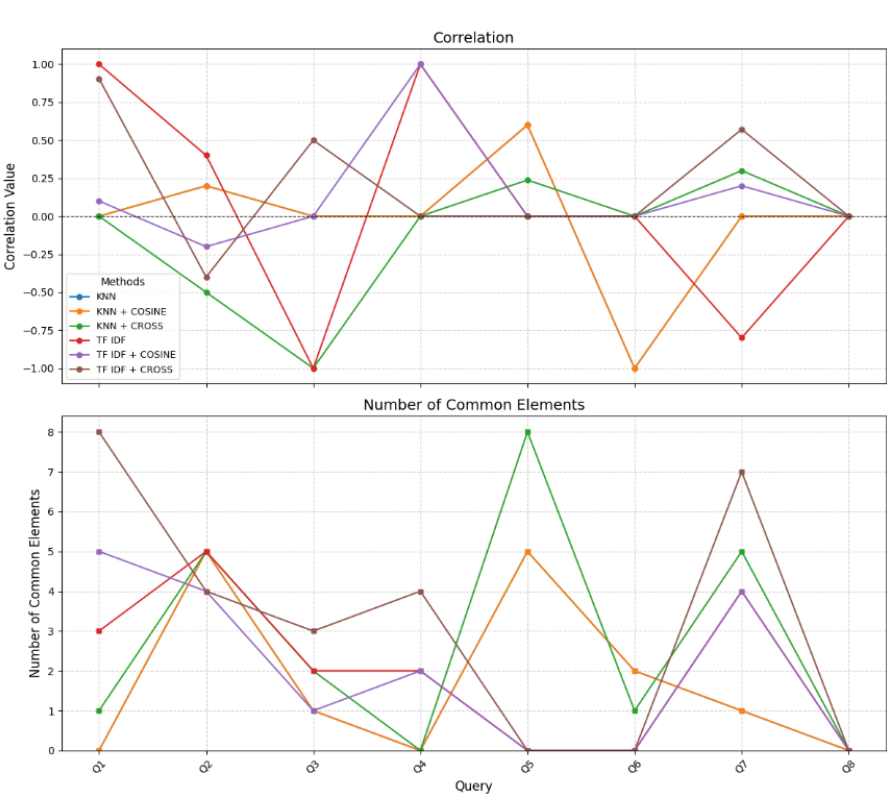

## Example

In [ ]:
tf_idf_res=tf_idf_indexing("pasta banana")


In [ ]:
ref_data[0]['result'][0]["id"]

1298794

In [ ]:
compare_rankings(tf_idf_res,ref_data[0]["result"])

{'correlation': np.float64(0.9999999999999999),
 'num_discrepancies': 2,
 'discrepancies': [{'id': 1298794, 'pos_mine': 1, 'pos_ref': 0, 'delta': 1},
  {'id': 1083821, 'pos_mine': 2, 'pos_ref': 1, 'delta': 1}]}

In [ ]:
tf_idf_res_q1=tf_idf_indexing(query)
knn_res_q1=knn_indexing(query)

In [ ]:
COS_TF=cosine_reordering(query,tf_idf_res_q1)
COS_KNN=cosine_reordering(query,knn_res_q1)


In [ ]:
CROSS_TF=cross_encoder_reordering(query,tf_idf_res_q1)
CROSS_KNN=cross_encoder_reordering(query,knn_res_q1)

[ 1.5819659   4.545738    3.3063307   1.583442    1.3789592  -0.04036031
  2.0723996   3.1620078   1.4403613   0.7542585   1.4440987   1.0119078
  1.7101368   2.769473    2.4277487   1.1349869   1.0675538   1.6520138
  1.7871355   1.8313736  -0.62870604  2.0004537   0.43428648  5.845925
  2.22154     1.9960304   0.62795794 -1.8889551   2.1279728   1.8033981
  1.2956617   0.96039295 -0.3193765  -0.73154676  1.2539918   0.01289282
  0.32001626 -0.903659    0.5053121  -0.98248327  1.4623914   2.3744526
  1.213859   -1.8485217  -0.3097558   0.67329955  0.31623167  0.8816004
 -2.3052607   0.5620465 ]
[23  1  2  7 13 14 41 24 28  6 21 25 19 29 18 12 17  3  0 40 10  8  4 30
 34 42 15 16 11 31 47  9 45 26 49 38 22 36 46 35  5 44 32 20 33 37 39 43
 27 48]
[-2.8379464  -2.9952478  -4.0547657  -3.3388157  -4.7761745  -4.138218
 -3.823774   -2.9669938  -3.5205684  -2.4830742  -3.7799876  -2.9741797
 -2.603281   -3.200108   -4.8837233  -3.421657   -3.9425156  -4.457383
 -4.7120137  -1.8399701  -0.3